In [ ]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import log, sqrt, sin, cos, exp, pi, prod
from autograd.numpy.random import normal, uniform

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import imageio
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

In [2]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.random.seed(2021)

In [3]:
def mixture(x):
    energy = ((x[0]**2 + x[1]**2)/10 - (cos(2.0*pi*x[0]) + cos(2.0*pi*x[1]))) / 0.5 # 2
    regularizer = ((x[0]**2 + x[1]**2) > 20) * ((x[0]**2 + x[1]**2) - 20)
    return energy + regularizer

def mixture_expand(x, y): return mixture([x, y])
def function_plot(x, y): return np.exp(-mixture([x, y]))

lower, upper = -2.5, 2.5
axis_x = np.linspace(lower, upper, 500)
axis_y = np.linspace(lower, upper, 500)
axis_X, axis_Y = np.meshgrid(axis_x, axis_y)

energy_grid = mixture_expand(axis_X, axis_Y)
prob_grid = function_plot(axis_X, axis_Y)

# Build SGLD Sampler (Single Chain)

In [ ]:
class Sampler:
    def __init__(self, f=None, dim=None, xinit=None, lr=0.1, T=1.0, decay_lr=100.):
        self.f = f
        self.dim = dim
        self.lr = lr
        self.T = T
        self.decay_lr = decay_lr
      
         
        # initialization for SGLD
        self.x = np.array(xinit)
        

    def stochastic_grad(self, beta):  return grad(self.f)(beta) + 0.25*normal(size=self.dim)

    def stochastic_f(self, beta): return self.f(beta.tolist()) + 0.25*normal(size=1)

    def sgld_step(self, iters):  
        self.x = self.x - self.lr * self.stochastic_grad(self.x) + sqrt(2. * self.lr * self.T) * normal(size=self.dim) 

## Call our sampler

In [ ]:
sampler = Sampler(f=mixture, dim=2, xinit=[0.,0.], lr=3e-3, T=1, decay_lr=3e-3)

In [ ]:
warm_up = 1000
sgld_x = np.array([sampler.x])

In [ ]:
my_images3 = []
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/SGLD_result/'
if not os.path.isdir(PATH):
    try:
        os.makedirs(PATH)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(PATH):
            pass
        else:
            raise

for iters in range(int(4e5)):
    sampler.sgld_step(iters)
    if iters > warm_up:
        if iters % 20 == 0:
            sgld_x = np.vstack((sgld_x, sampler.x))
        if iters % 2000 == 0:
              fig3 = plt.figure(figsize=(4, 4))
              plt.contour(axis_X, axis_Y, prob_grid, 10)
              plt.yticks([-4, -2, 0, 2, 4]) 
              plt.scatter(sgld_x[:,0], sgld_x[:,1], marker='.', s=3, color='k', label="Iteration="+str(iters)) 
              plt.legend(loc="upper left", prop={'size': 10})
              plt.xlim([lower, upper])
              plt.ylim([lower, upper])
              # plt.tight_layout()
              plt.show()
              fig3.canvas.draw()
              image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
              my_images3.append(image3)
              plt.close('all')
          

imageio.mimsave(PATH+'SGLD_contour_'+str(sampler.lr)+"_"+str(sampler.T)+'.gif', my_images3, fps=50)      
# imageio.mimsave(PATH+'CSGLD_PDF'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.gif', my_images4, fps=50)

# save the sampels
import pickle
f = open(PATH + 'SGLD_samples.txt', 'wb')
pickle.dump(sgld_x, f)
f.close()
            

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


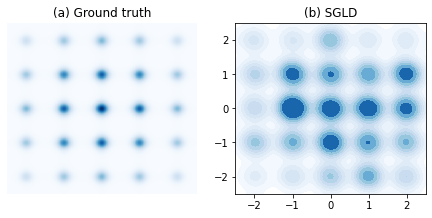

In [ ]:
fig = plt.figure(figsize=(7.5, 3.15))
plt.subplot(1, 2, 1).set_title('(a) Ground truth')
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False).invert_yaxis()

warm_sample = 50
split_ = 1
plt.subplot(1, 2, 2).set_title('(b) SGLD')
ax = sns.kdeplot(sgld_x[:,0][::split_][warm_sample:], sgld_x[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig(PATH+"SGLD_"+str(sampler.lr)+"_"+str(sampler.T)+".png")

# Build Parallel SGLD Sampler

In [5]:
class PSampler:
    def __init__(self, f=None, dim=None, boundary=None, xinit=None, \
                 partition=None, lr=0.1, zeta=1.0, T=1.0, decay_lr=100., parts=100):
        self.N = len(xinit) # number of parallel markov chain
        self.f = f
        self.dim = dim
        self.lr = lr
        self.T = T
     
        # initialization for SGLD
        self.x = np.array(xinit)
       
    def stochastic_grad(self, beta):  return grad(self.f)(beta) + 0.25*normal(size=self.dim)

    def stochastic_f(self, beta): return self.f(beta.tolist()) + 0.25*normal(size=1)

     
    def sgld_step(self, iters):        
        self.x = [self.x[i] - self.lr * self.stochastic_grad(self.x[i]) 
        + sqrt(2. * self.lr * self.T) * normal(size=self.dim) for i in range(self.N)]

Call our sampler

In [6]:
psampler = PSampler(f=mixture, dim=2, xinit=[[0.,-1.],[0.,0.],[-1.,0.],[0.,1.],[1.,0.]], lr=3e-3, T=1, decay_lr=3e-3)

In [7]:
warm_up = 1000
sgld_x = np.array(psampler.x)

In [8]:
my_images3 = []
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/SGLD_result/'
if not os.path.isdir(PATH):
    try:
        os.makedirs(PATH)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(PATH):
            pass
        else:
            raise

np.random.seed(2021)
for iters in range(int(8e4)):
    psampler.sgld_step(iters)
    if iters > warm_up:
        if iters % 20 == 0:
            sgld_x = np.vstack((sgld_x, psampler.x))
        if iters % 400 == 0:
              fig3 = plt.figure(figsize=(4, 4))
              plt.contour(axis_X, axis_Y, prob_grid, 10)
              plt.yticks([-4, -2, 0, 2, 4]) 
              plt.scatter(sgld_x[:,0], sgld_x[:,1], marker='.', s=3, color='k', label="Iteration="+str(iters)) 
              plt.legend(loc="upper left", prop={'size': 10})
              plt.xlim([lower, upper])
              plt.ylim([lower, upper])
              # plt.tight_layout()
              plt.show()
              fig3.canvas.draw()
              image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
              my_images3.append(image3)
              plt.close('all')
          

imageio.mimsave(PATH+'Population_SGLD_contour_'+str(psampler.lr)+"_"+str(psampler.T)+'.gif', my_images3, fps=50)      
# imageio.mimsave(PATH+'CSGLD_PDF'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.gif', my_images4, fps=50)

# save the sampels
import pickle
f = open(PATH + 'population_SGLD_samples.txt', 'wb')
pickle.dump(sgld_x, f)
f.close()            

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


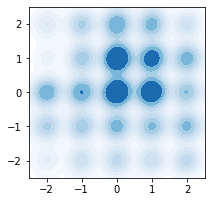

In [9]:
fig = plt.figure(figsize=(3.15, 3.15))

warm_sample = 50
split_ = 1
plt.subplot(1, 1, 1)
ax = sns.kdeplot(sgld_x[:,0][::split_][warm_sample:], sgld_x[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig(PATH+"population_SGLD.png")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


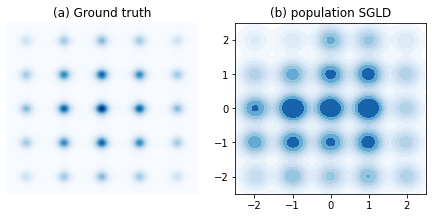

In [ ]:
fig = plt.figure(figsize=(7.5, 3.15))
plt.subplot(1, 2, 1).set_title('(a) Ground truth')
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False).invert_yaxis()

warm_sample = 50
split_ = 1
plt.subplot(1, 2, 2).set_title('(b) population SGLD')
ax = sns.kdeplot(sgld_x[:,0][::split_][warm_sample:], sgld_x[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig(PATH+"population_SGLD_"+str(psampler.lr)+"_"+str(psampler.T)+".png")